In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image, UnidentifiedImageError
import time
from google.colab import drive

# ===================
# 1. MONTAGEM DO DRIVE
# ===================
drive.mount('/content/drive')

# ===================
# 2. ANÁLISE DE DISTRIBUIÇÃO DE CLASSES
# ===================
def analisar_distribuicao(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.encode('utf-8').str.decode('utf-8').str.strip()
    df['Categoria'] = df['Achado - Categoria'].str.extract(r'Categoria\s*(\d)')
    df = df.dropna(subset=['Categoria'])
    df['Categoria'] = df['Categoria'].astype(int)
    contagem = df['Categoria'].value_counts().sort_index()
    print(f"\nDistribuicao em {csv_path}:")
    print(contagem)
    contagem.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribuicao por Categoria BI-RADS')
    plt.xlabel('Categoria BI-RADS')
    plt.ylabel('Quantidade')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

analisar_distribuicao("/content/drive/MyDrive/imgCeonc/treinamento/resultados_multilinhas.csv")
analisar_distribuicao("/content/drive/MyDrive/imgCeonc/validacao/resultados_multilinhas.csv")

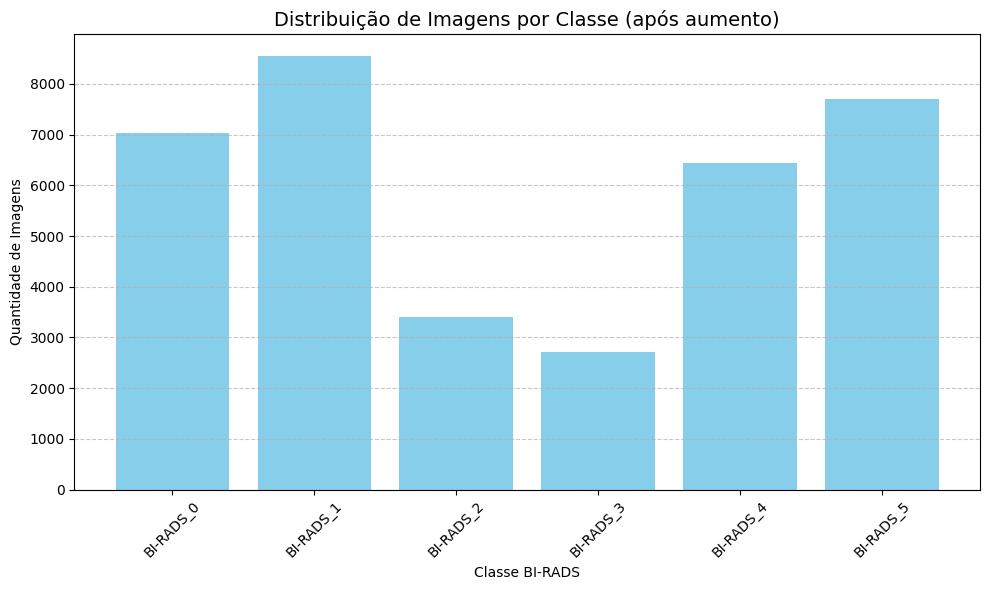

In [9]:
import matplotlib.pyplot as plt

# Caminho para o diretório onde estão as pastas BI-RADS
caminho_base = '/content/drive/MyDrive/imgCeonc/treinamento/images'

# Lista para armazenar os dados
classes = []
quantidades = []

# Percorrer as pastas dentro do diretório base
for nome_classe in sorted(os.listdir(caminho_base)):
    caminho_classe = os.path.join(caminho_base, nome_classe)
    if os.path.isdir(caminho_classe):
        num_imagens = len([f for f in os.listdir(caminho_classe) if f.endswith('.png') or f.endswith('.jpg')])
        classes.append(nome_classe)
        quantidades.append(num_imagens)

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.bar(classes, quantidades, color='skyblue')
plt.title('Distribuição de Imagens por Classe (após aumento)', fontsize=14)
plt.xlabel('Classe BI-RADS')
plt.ylabel('Quantidade de Imagens')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# ===================
# 3. LIMPEZA DE IMAGENS CORROMPIDAS
# ===================
def remover_imagens_corrompidas(pasta_raiz):
    extensoes_validas = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    for root, _, files in os.walk(pasta_raiz):
        for nome in files:
            if nome.lower().endswith(extensoes_validas):
                caminho = os.path.join(root, nome)
                try:
                    with Image.open(caminho) as img:
                        img.verify()
                except Exception:
                    print(f"Removendo imagem corrompida: {caminho}")
                    os.remove(caminho)

#remover_imagens_corrompidas('/content/drive/MyDrive/imgCeonc/treinamento/images')
#remover_imagens_corrompidas('/content/drive/MyDrive/imgCeonc/validacao/images')

In [ ]:
# ===================
# 4. TRANSFORMACOES E DATASETS
# ===================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dir = "/content/drive/MyDrive/imgCeonc/treinamento/images"
val_dir = "/content/drive/MyDrive/imgCeonc/validacao/images"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
class_names = train_dataset.classes

# Amostragem balanceada
labels = [label for _, label in train_dataset]
class_sample_counts = np.bincount(labels)
weights = 1. / class_sample_counts
sample_weights = [weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
# ===================
# 5. FUNCAO DE TREINAMENTO + AVALIACAO
# ===================
def treinar_avaliar(optimizer_fn, optimizer_name):
    print(f"\n======================\nTreinando com: {optimizer_name}\n======================")
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters())

    for epoch in range(5):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch {epoch+1} | Loss: {running_loss:.4f} | Acc: {acc:.2f}% | Time: {time.time() - start_time:.1f}s")

    # Avaliação
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n📊 Relatório de Classificação:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title(f"Matriz de Confusão - {optimizer_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
# ===================
# 6. EXECUCAO COM DIFERENTES OTIMIZADORES
# ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

treinar_avaliar(lambda params: optim.Adam(params, lr=0.0001), "Adam")
treinar_avaliar(lambda params: optim.SGD(params, lr=0.01, momentum=0.9), "SGD")
treinar_avaliar(lambda params: optim.RMSprop(params, lr=0.0001), "RMSprop")


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import random
from google.colab import drive
drive.mount('/content/drive')

# Define as transformações
def get_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-20, 20)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    ])

def aumentar_classe(pasta_classe, num_copias=5):
    transform = get_transform()
    imagens = os.listdir(pasta_classe)
    for nome in imagens:
        caminho = os.path.join(pasta_classe, nome)
        try:
            imagem = Image.open(caminho).convert("RGB")
            for i in range(num_copias):
                transformada = transform(imagem)
                novo_nome = f"aug_{i}_{nome}"
                transformada.save(os.path.join(pasta_classe, novo_nome))
        except Exception as e:
            print(f"Erro com {nome}: {e}")
            continue

# Aumentar só classes desbalanceadas
#aumentar_classe('/content/drive/MyDrive/imgCeonc/treinamento/images/BI-RADS_0', num_copias=10)
aumentar_classe('/content/drive/MyDrive/imgCeonc/treinamento/images/BI-RADS_3', num_copias=10)
#aumentar_classe('/content/drive/MyDrive/imgCeonc/treinamento/images/BI-RADS_4', num_copias=20)
#aumentar_classe('/content/drive/MyDrive/imgCeonc/treinamento/images/BI-RADS_5', num_copias=30)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
